# Übung 4.1 : Das Traglinienverfahren und die Prandtl'sche Tragflügeltheorie - Trapezflügel

<div style="text-align: justify"> </p>Die Übung 4 ist die erste von insgesamt fünf computer-basierten Übungen und soll einen ersten Einblick in aerodynamische Optimierungsaufgaben geben und wie sie mit Algorithmen gelöst werden können. </p>

Die **Prandtl'sche Traglinientheorie (engl. "lifting line theory")** besteht seit der Zeit des ersten Weltkrieges und findet heutzutage immernoch Anwendung. Darauf basierend wird das numerische Traglinienverfahren als analytische Methode eingesetzt, um im Flügel-Vorentwurf Vorhersagen über Effizienz und Verluste von Tragflügeln endlicher Streckung zu treffen.

#### Was liefert die Traglinientheorie?
- Auftriebsverteilung entlang der Spannweite
- Auftriebskraft 
- Induzierter Widerstand (Effizienz)

#### Was sind die Einschränkungen?
- gilt nur für große Streckungen
- Pfeilung kann nicht berücksichtigt werden 
- gilt nur für kleine Anstellwinkel

Die ausführliche Theorie zum Verfahren findet ihr in den Skripten begleitend zur Vorlesung. Nachfolgend soll nun exemplarisch gezeigt werden, wie ein solches Traglinienverfahren in Python implementiert werden kann
 </div>

In [432]:
# Importieren von Python-Biblioteken
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, IntSlider, FloatSlider, fixed, VBox, HBox, Label
import ipywidgets as widgets

# increase plot resolution
plt.rcParams["figure.dpi"] = 160

### Hinweis zum bearbeiten der Notebooks:

Das orangene Symbol 🟠 kennzeichnet Bereiche, in denen Parameter geändert werden können bzw. sollen. Dies beinhaltet vor allem Geometrie- und Randparameter.

## Aufgabe 4.1 a)
Untersuchen Sie am Beispiel des Rechteckflügels mit $l_i=1$ und $\Lambda = 10$ das Konvergenzverhalten der aerodynamischen Beiwerte ($C_W$, $C_A$) und des Oswald Faktors hinsichtlich der Abhängigkeit von der Anzahl der Elementarflügel (räumliche Diskretisierung).
Entscheiden Sie sich für eine Diskretisierung für alle folgenden Aufgabenteil und begründen Sie diese Entscheidung.

### 4.1.1 Visualisierung: Trapezflügel

In [433]:
def trapezfluegel(l_a, AR, l_i=1.0) -> np.array:
    """Generiert die Planform eines Doppeltrapezflügels auf Basis der gegebenen Flügeltiefen und Streckung"""

    # Berechnung der Halbspannweite
    b = (l_a + l_i) * AR / 2
    s = b / 2

    # Definition aller Eckpunkte
    points = np.array([
        [0, 0], [s, -l_a/2 + l_i/2], [s, l_a/2 + l_i/2], [0, l_i], 
        [-s, l_a/2 + l_i/2], [-s, -l_a/2  + l_i/2], [0, 0]
    ])
    
    return points

def plot_trapezfluegel(l_a, AR):
    """Plottet die Planform eines Doppeltrapezflügels auf Basis der gegebenen Flügeltiefen und Streckung"""
    
    # Flügeleckpunkte generieren
    points = trapezfluegel(l_a, AR)

    # Geometrie plotten
    plt.figure(figsize=(10, 6))
    plt.plot(points[:,0], points[:, 1], '-', color="black")
    plt.vlines(0, 0, 1, "black", "--")
    plt.xlabel('Spannweite [m]')
    plt.ylabel('Flügeltiefe [m]')
    plt.title('Doppeltrapezflügel')
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.show()

def widget_trapezfluegel():
    """Erzeugt ein widget, mit dem sich die Planform eines Doppeltrapezflügels interaktiv visualisieren lässt"""

    slider_l_a = VBox([Label('Flügeltiefe außen'), FloatSlider(value=0.5, min=0, max=1.0, step=0.1)])
    slider_AR = VBox([Label('Streckung'), FloatSlider(value=10, min=5, max=20, step=1)])

    # Interaktiver plot
    ui = VBox([slider_l_a, slider_AR])
    ui = VBox([ui], layout=widgets.Layout(justify_content='center'))
    out = widgets.interactive_output(plot_trapezfluegel, {'l_a': slider_l_a.children[1], 'AR': slider_AR.children[1]})

    return HBox([out, ui])

In [434]:
display(widget_trapezfluegel())

### 4.1.2 Geometrische Parameter und Randbedinungen

In [435]:
# Konstant
alpha = 5                       # Anstellwinel [deg]
alpha = alpha / 180 * np.pi     # Anstellwinel [rad]  
# TODO
alpha = 1
U_inf = 10.0                    # Anströmgeschwindigkeit [m/s]
rho = 1.225                     # Dichte [kg/m^3]
l_i = 1.0                       # Flügeltiefe Wurzel [m]

#### 🟠

In [436]:
l_a = 1                       # Flügeltiefe außen [m]
AR = 10                         # Streckung/ Aspect Ratio

#### Berechnung weiterer geometrischer Parameter

In [437]:
# Berechnung der Halbspannweite
b = (l_i + l_a) * AR / 2
s = b / 2 

# Berechnung der Flügelfläche aus Halbspannweite und Streckung
S = b/2 * (l_a + l_i)       

# Ausgabe
print("Spannweite:                  ", "%.2f" % b, "m")
print("Halbspannweite:              ", "%.2f" % s, "m")
print("Flügelfläche:                ", "%.2f" % S, "m^2")

Spannweite:                   10.00 m
Halbspannweite:               5.00 m
Flügelfläche:                 10.00 m^2


### 4.1.4 Berechnung der Hufeisenwirbel-Koordinaten

In [438]:
def tiefe_trapez(y, l_a, s) -> float:
    """Berechnet mit gegebenen Geometriepartametern eines Doppeltrapezflügels die lokale Flügeltiefe für eine spannweitige Position"""
    return 1 + (l_a - 1) * (abs(y) / s)
    
def plot_diskretisierung_trapez(l_a, AR, s, N):
    """Plottet die Diskretisierung eines Doppeltrapezflügels auf Basis der Anzahl der Elementarflügel"""
    points = trapezfluegel(l_a, AR)
    
    # Diskretisierung der Halbspannweite
    y_values = np.linspace(-s, s, N+1)
    chord_values = [tiefe_trapez(y, l_a, s) for y in y_values]
    
    # Geometrie plotten
    plt.figure(figsize=(10, 6))
    plt.plot(points[:,0], points[:, 1], '-', color="black")

    # Elementarflügel plotten
    for i in range(N):
        plt.plot([y_values[i], y_values[i]], [-chord_values[i]/2 + l_i/2, chord_values[i]/2 + l_i/2], 'g-')
    
    plt.vlines(0, 0, 1, "black", "--")
    plt.xlabel('Spannweite [m]')
    plt.ylabel('Flügeltiefe [m]')
    plt.title('Diskretisierung Trapezflügel')
    plt.axis('equal')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()

def widget_diskretisierung_trapez(l_a, AR, s):
    """Erzeugt ein widget, mit dem sich die Diskretisierung eines Doppeltrapezflügels interaktiv visualisieren lässt"""

    slider_N = VBox([Label('Anzahl der Elementarflügel'), IntSlider(value=30, min=1, max=100, step=1)])

    # Interaktiver plot
    ui = VBox([slider_N])
    ui = VBox([ui], layout=widgets.Layout(justify_content='center'))
    out = widgets.interactive_output(plot_diskretisierung_trapez, {'l_a': fixed(l_a), 'AR': fixed(AR), "s": fixed(s), 'N': slider_N.children[1]})
    return HBox([out, ui])

In [439]:
display(widget_diskretisierung_trapez(l_a, AR, s))

Zur Bestimmung der $N$ (Variable n) unbekannten Wirbelstärken $\Gamma$ wird die kinematische Strömungsbedingung in den $N$ (Variable $m$) Aufpunkten erfüllt, und man hat ein lineares Gleichungssystem zu lösen. Dafür werden die Koordinaten des tragenden Wirbels entlang der örtlichen $l_p/4$-Linie (indizes a, b) am Rand jedes Elementarflügels sowie die der Aufpunkte im $3l_p/4$–Punkt des Mittelschnittes jedes Elementarflügels (index c) bestimmt.

#### 🟠

In [440]:
# # Anzahl der Elementarflügel und Breite eines Elementarflügels
N = 500              
delta_b = b/N                  

In [441]:
# Spannweitige Positionen der Punkte A, B und Aufpunkt C
y_a = np.array([-s +  j    * delta_b for j in range(N)])
y_b = np.array([-s + (j+1) * delta_b for j in range(N)])
y_c = np.array([-s + delta_b/2 + i*delta_b for i in range(N)])

# Tiefenposition der Punkte A und B und Aufpunkt C
def x_position(y, l_i, l_a, s, aufpunkt=False):
    tiefe = 0.75 if aufpunkt else 0.25
    return abs(y) / s * (l_i - l_a) / 2 + tiefe * (l_i - abs(y) / s * (l_i - l_a))
    
x_a = np.array([x_position(y_i, l_i, l_a, s) for y_i in y_a])
x_b = np.array([x_position(y_i, l_i, l_a, s) for y_i in y_b])
x_c = np.array([x_position(y_i, l_i, l_a, s, True) for y_i in y_c])

# Spannweitige Positionen der bis ins Unendliche reichenden nichttragenden Wirbel
y_aoo = np.array([-s +  j    * delta_b for j in range(N)])
y_boo = np.array([-s + (j+1) * delta_b for j in range(N)])

# Tiefenposition der bis ins Unendliche reichenden nichttragenden Wirbel
x_aoo = x_a + 100*s
x_boo = x_b + 100*s

In [442]:
print("Punkt A:     :", y_a[0], x_a[0])
print("Punkt Aoo    :", y_aoo[0], x_aoo[0])
print("Punkt C:     :", y_c[0], x_c[0])
print("Punkt B:     :", y_b[0], x_b[0])
print("Punkt Boo    :", y_boo[0], x_boo[0])

Punkt A:     : -5.0 0.25
Punkt Aoo    : -5.0 500.25
Punkt C:     : -4.99 0.75
Punkt B:     : -4.98 0.25
Punkt Boo    : -4.98 500.25


### 4.1.5 Berechnung der Koeffizientenmatrix

In [443]:
# initialisieren der Matrizen
a_AB = np.zeros((x_a.size, x_a.size))
a_Aoo = np.zeros((x_a.size, x_a.size))
a_Boo = np.zeros((x_a.size, x_a.size))

for j in range(N):
    for i in range(N):
        a_AB[i, j] = 1 / (4*np.pi) * (1/((x_c[i] - x_a[j])*(y_c[i] - y_b[j]) - (y_c[i] - y_a[j])*(x_c[i] - x_b[j]))) * (((x_b[j] - x_a[j])*(x_c[i] - x_a[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_a[j]))/ np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2) - ((x_b[j] - x_a[j])*(x_c[i] - x_b[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_b[j]))/ np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2))

for j in range(N):
    for i in range(N):
        a_Aoo[i, j] = 1 / (4*np.pi) * 1/(y_a[j] - y_c[i]) * ((x_c[i] - x_a[j])/ (np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2)) + 1)

for j in range(N):
    for i in range(N):
        a_Boo[i, j] = 1 / (4*np.pi) * 1/(y_b[j] - y_c[i]) * ((x_c[i] - x_b[j])/ (np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2)) + 1)

Die Koeffizientenmatrix `a` ist die Summe der gebundenen und freien Wirbel.
Die Koeffizientenmatrix der induzierenden Wirbel `a_ind` ist die Summe der freien Wirbel.
Die Wirbelstärken `Gamma` werden aus Inverser der Koeffizientenmatrix, Anstellwinkelvektor und Anströmgeschwindigkeit berechnet.

In [444]:
a = a_AB + a_Aoo - a_Boo                # Koeffizientenmatrix
a_ind = a_Aoo - a_Boo                   # Koeffizientenmatrix der induzierenden Wirbel
alpha_g = np.full((x_a.size), alpha)    # Anstellwinkelvektor

Gamma = np.linalg.solve(a, alpha_g * (- U_inf)) # löst Ax = B

### 4.1.6 Berechnung von Kräften und Beiwerten

In [445]:
# Berechnung des Auftriebs nach Kutta-Joukowsky
A_j = rho * delta_b * U_inf * Gamma
A = np.sum(A_j)

# Berechnung des induzierten Widerstands
w_m = a_ind @ Gamma
W_ind = np.sum(-rho *w_m @ Gamma * delta_b)

print("Auftrieb:                    ", "%.2f" % A, "N")
print("Induzierter Widerstand:      ", "%.2f" % W_ind, "N")

Auftrieb:                     2953.71 N
Induzierter Widerstand:       662.07 N


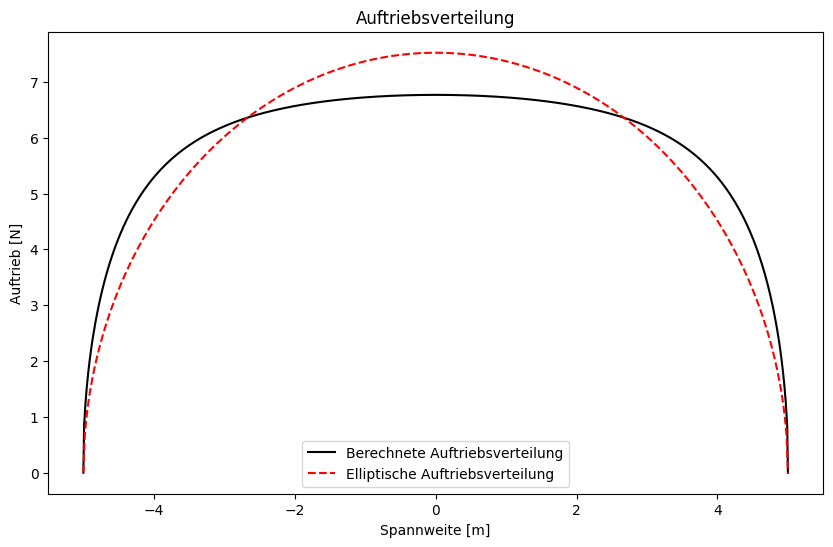

In [446]:
# Auftriebsverteilung plotten

# Hinzufügen von Endpunkten zum plotten
A_j = np.insert(A_j, 0, 0)
A_j = np.append(A_j, 0)
y_c = np.insert(y_c, 0, -s)
y_c = np.append(y_c, s)

# Berechne die Fläche unter der berechneten Auftriebsverteilung
area_distr = np.trapz(A_j, y_c)

# Erzeuge die elliptische Auftriebsverteilung
y_elliptisch = np.linspace(-s, s, len(y_c))
A_elliptisch_raw = np.sqrt(1 - (y_elliptisch / s) ** 2)

# Skaliere die elliptische Verteilung so, dass die Flächen gleich sind
area_elliptisch_raw = np.trapz(A_elliptisch_raw, y_elliptisch)
scale_factor = area_distr / area_elliptisch_raw
A_elliptisch = A_elliptisch_raw * scale_factor

# Plotten der Auftriebsverteilungen
plt.figure(figsize=(10, 6))
plt.plot(y_c, A_j, '-', color="black", label='Berechnete Auftriebsverteilung')
plt.plot(y_elliptisch, A_elliptisch, '--', color="red", label='Elliptische Auftriebsverteilung')
plt.xlabel('Spannweite [m]')
plt.ylabel('Auftrieb [N]')
plt.title('Auftriebsverteilung')
plt.legend()
plt.show()

In [447]:
# Auftriebsbeiwert
C_A = 2*A / rho / U_inf**2 / S

# Widerstandsbeiwert (induziert)
C_W_ind = 2*W_ind / rho / U_inf**2 / S

print("Auftriebsbeiwert:            ", "%.5f" % C_A)
print("Widerstandsbeiwert:          ", "%.5f" % C_W_ind)

Auftriebsbeiwert:             4.82238
Widerstandsbeiwert:           1.08094


In [448]:
# Induzierter Widerstand der elliptischen Zirkulationsverteilung
C_W_ind_ell = C_A**2 / AR / np.pi

# Oswald Faktor
Oswald = C_W_ind_ell / C_W_ind

print("Widerstandsbeiwert (Ellipse):", "%.5f" % C_W_ind_ell)
print("Oswald-Faktor:               ", "%.2f" % Oswald)

Widerstandsbeiwert (Ellipse): 0.74024
Oswald-Faktor:                0.68


## Aufgabe 1 a) Konvergenzstudie

Untersuchen Sie am Beispiel des Rechteckflügels mit $l_i=1$ und $\Lambda = 10$ das Konvergenzverhalten der aerodynamischen Beiwerte ($C_W$, $C_A$) und des Oswald Faktors hinsichtlich der Abhängigkeit von der Anzahl der Elementarflügel (räumliche Diskretisierung).
Entscheiden Sie sich für eine Diskretisierung für alle folgenden Aufgabenteile und begründen Sie diese Entscheidung.

In [449]:
N_study = [10, 15, 25, 50, 100, 200, 500, 750, 1000]
C_A, C_W_ind, Oswald = [], [], []

for c, N in enumerate(N_study):
    delta_b = b/N
    
    # Spannweitige Positionen der Punkte A, B und Aufpunkt C
    y_a = np.array([-s +  j    * delta_b for j in range(N)])
    y_b = np.array([-s + (j+1) * delta_b for j in range(N)])
    y_c = np.array([-s + delta_b/2 + i*delta_b for i in range(N)])

    # Tiefenposition der Punkte A und B und Aufpunkt C
    def x_position(y, l_i, l_a, s, aufpunkt=False):
        tiefe = 0.75 if aufpunkt else 0.25
        return abs(y) / s * (l_i - l_a) / 2 + tiefe * (l_i - abs(y) / s * (l_i - l_a))
        
    x_a = np.array([x_position(y_i, l_i, l_a, s) for y_i in y_a])
    x_b = np.array([x_position(y_i, l_i, l_a, s) for y_i in y_b])
    x_c = np.array([x_position(y_i, l_i, l_a, s, True) for y_i in y_c])

    # Spannweitige Positionen der bis ins Unendliche reichenden nichttragenden Wirbel
    y_aoo = np.array([-s +  j    * delta_b for j in range(N)])
    y_boo = np.array([-s + (j+1) * delta_b for j in range(N)])

    # Tiefenposition der bis ins Unendliche reichenden nichttragenden Wirbel
    x_aoo = x_a + 100*s
    x_boo = x_b + 100*s

    a_AB = np.zeros((x_a.size, x_a.size))
    a_Aoo = np.zeros((x_a.size, x_a.size))
    a_Boo = np.zeros((x_a.size, x_a.size))

    for j in range(N):
        for i in range(N):
            a_AB[i, j] = 1 / (4*np.pi) * (1/((x_c[i] - x_a[j])*(y_c[i] - y_b[j]) - (y_c[i] - y_a[j])*(x_c[i] - x_b[j]))) * (((x_b[j] - x_a[j])*(x_c[i] - x_a[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_a[j]))/ np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2) - ((x_b[j] - x_a[j])*(x_c[i] - x_b[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_b[j]))/ np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2))

    for j in range(N):
        for i in range(N):
            a_Aoo[i, j] = 1 / (4*np.pi) * 1/(y_a[j] - y_c[i]) * ((x_c[i] - x_a[j])/ (np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2)) + 1)

    for j in range(N):
        for i in range(N):
            a_Boo[i, j] = 1 / (4*np.pi) * 1/(y_b[j] - y_c[i]) * ((x_c[i] - x_b[j])/ (np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2)) + 1)

    a = a_AB + a_Aoo - a_Boo                # Koeffizientenmatrix
    a_ind = a_Aoo - a_Boo                   # Koeffizientenmatrix der induzierenden Wirbel
    alpha_g = np.full((x_a.size), alpha)    # Anstellwinkelvektor

    # die Wirbelstärken werden aus Inverser der Koeffizientenmatrix, Anstellwinkelvektor und Anströmgeschwindigkeit berechnet
    Gamma = np.linalg.solve(a, alpha_g * (- U_inf)) # löst Ax = B

    # Berechnung des Auftriebs nach Kutta-Joukowsky
    A_j = rho * delta_b * U_inf * Gamma
    A = np.sum(A_j)

    # Berechnung des induzierten Widerstands
    w_ind = a_ind @ Gamma
    W_ind = np.sum(-rho *w_ind @ Gamma * delta_b)

    # Auftriebsbeiwert
    C_A.append(2*A / (rho * U_inf**2 * S))

    # Widerstandsbeiwert (induziert)
    C_W_ind.append(2*W_ind / (rho * U_inf**2 * S))

    # Induzierter Widerstand der elliptischen Zirkulationsverteilung
    C_W_ind_ell = C_A[c]**2 / AR / np.pi

    # Oswald Faktor
    Oswald.append(C_W_ind_ell / C_W_ind[c])

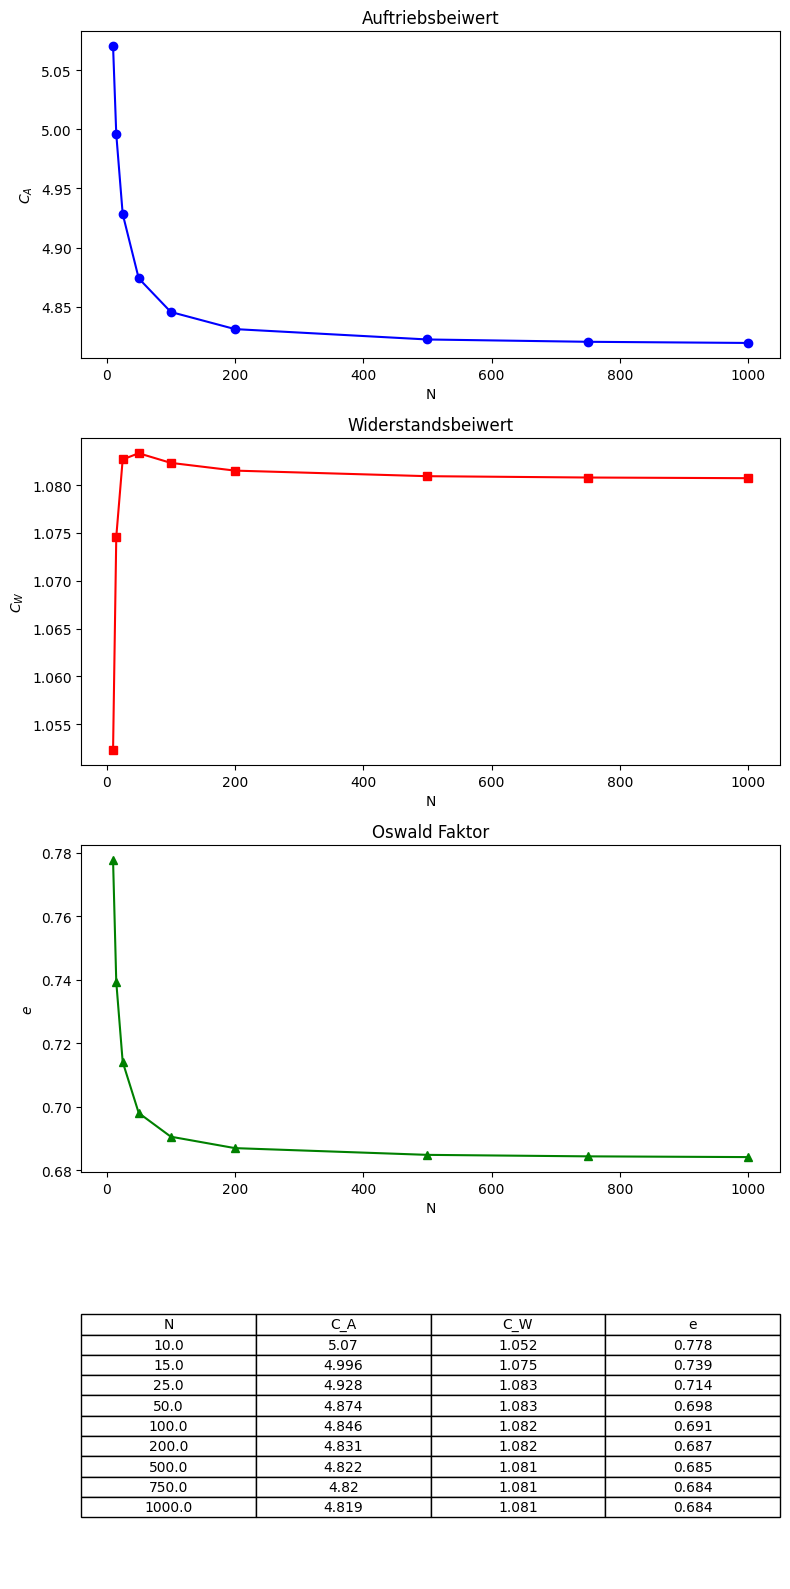

In [450]:
# Erstelle ein DataFrame
data = {
    'N': N_study,
    'C_A': [round(num, 3) for num in C_A],
    'C_W': [round(num, 3) for num in C_W_ind],
    'e': [round(num, 3) for num in Oswald]
}
df = pd.DataFrame(data)

# Erstelle die Subplots
fig, axs = plt.subplots(4, 1, figsize=(8, 16))

# Plot für C_A
axs[0].plot(N_study, C_A, marker='o', linestyle='-', color='b')
axs[0].set_xlabel(r"N")
axs[0].set_ylabel(r'$C_A$')
axs[0].set_title("Auftriebsbeiwert")

# Plot für C_W_ind
axs[1].plot(N_study, C_W_ind, marker='s', linestyle='-', color='r')
axs[1].set_xlabel(r"N")
axs[1].set_ylabel(r'$C_W$')
axs[1].set_title("Widerstandsbeiwert")

# Plot für Oswald
axs[2].plot(N_study, Oswald, marker='^', linestyle='-', color='g')
axs[2].set_xlabel(r"N")
axs[2].set_ylabel(r'$e$')
axs[2].set_title("Oswald Faktor")

# Erstelle die Tabelle
axs[3].axis('tight')
axs[3].axis('off')
table = axs[3].table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Automatisches Layout anpassen
plt.tight_layout()

# Zeige die Plots an
plt.show()

## Aufgabe 1 b) Einfluss der Zuspitzung

Optimieren Sie vier Trapezflügel mit $\Lambda = 3, 7, 10, 20$ und $l_i = 1$ über eine Variation der Flügeltiefe an der Flügelspitze hin zu einer möglichst widerstandsarmen zirkulationsverteilung. Aus der letzten Aufgabe ergab sich das eine Anzahl von 500 Elementarflügeln für eine ausreichende Konvergenz genügt.

In [478]:
N = 500
delta_b = b/N

AR_study = [3, 7, 10, 20]
l_a_study = [0.0, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.23, 0.25, 0.3, 0.35, 0.5, 0.75, 1]

result = {"lambda": l_a_study}

for AR in AR_study:
    oswald = []
    for l_a in l_a_study:

        # Berechnung der Halbspannweite
        b = (l_i + l_a) * AR / 2
        s = b / 2 

        # Berechnung der Flügelfläche aus Halbspannweite und Streckung
        S = b/2 * (l_a + l_i)  

        delta_b = b/N

        # Spannweitige Positionen der Punkte A, B und Aufpunkt C
        y_a = np.array([-s +  j    * delta_b for j in range(N)])
        y_b = np.array([-s + (j+1) * delta_b for j in range(N)])
        y_c = np.array([-s + delta_b/2 + i*delta_b for i in range(N)])

        # Tiefenposition der Punkte A und B und Aufpunkt C
        def x_position(y, l_i, l_a, s, aufpunkt=False):
            tiefe = 0.75 if aufpunkt else 0.25
            return abs(y) / s * (l_i - l_a) / 2 + tiefe * (l_i - abs(y) / s * (l_i - l_a))
            
        x_a = np.array([x_position(y_i, l_i, l_a, s) for y_i in y_a])
        x_b = np.array([x_position(y_i, l_i, l_a, s) for y_i in y_b])
        x_c = np.array([x_position(y_i, l_i, l_a, s, True) for y_i in y_c])

        # Spannweitige Positionen der bis ins Unendliche reichenden nichttragenden Wirbel
        y_aoo = np.array([-s +  j    * delta_b for j in range(N)])
        y_boo = np.array([-s + (j+1) * delta_b for j in range(N)])

        # Tiefenposition der bis ins Unendliche reichenden nichttragenden Wirbel
        x_aoo = x_a + 100*s
        x_boo = x_b + 100*s

        a_AB = np.zeros((x_a.size, x_a.size))
        a_Aoo = np.zeros((x_a.size, x_a.size))
        a_Boo = np.zeros((x_a.size, x_a.size))

        for j in range(N):
            for i in range(N):
                a_AB[i, j] = 1 / (4*np.pi) * (1/((x_c[i] - x_a[j])*(y_c[i] - y_b[j]) - (y_c[i] - y_a[j])*(x_c[i] - x_b[j]))) * (((x_b[j] - x_a[j])*(x_c[i] - x_a[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_a[j]))/ np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2) - ((x_b[j] - x_a[j])*(x_c[i] - x_b[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_b[j]))/ np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2))

        for j in range(N):
            for i in range(N):
                a_Aoo[i, j] = 1 / (4*np.pi) * 1/(y_a[j] - y_c[i]) * ((x_c[i] - x_a[j])/ (np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2)) + 1)

        for j in range(N):
            for i in range(N):
                a_Boo[i, j] = 1 / (4*np.pi) * 1/(y_b[j] - y_c[i]) * ((x_c[i] - x_b[j])/ (np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2)) + 1)

        a = a_AB + a_Aoo - a_Boo                # Koeffizientenmatrix
        a_ind = a_Aoo - a_Boo                   # Koeffizientenmatrix der induzierenden Wirbel
        alpha_g = np.full((x_a.size), alpha)    # Anstellwinkelvektor

        # die Wirbelstärken werden aus Inverser der Koeffizientenmatrix, Anstellwinkelvektor und Anströmgeschwindigkeit berechnet
        Gamma = np.linalg.solve(a, alpha_g * (- U_inf)) # löst Ax = B

        # Berechnung des Auftriebs nach Kutta-Joukowsky
        A_j = rho * delta_b * U_inf * Gamma
        A = np.sum(A_j)

        # Berechnung des induzierten Widerstands
        w_ind = a_ind @ Gamma
        W_ind = np.sum(-rho *w_ind @ Gamma * delta_b)

        # Auftriebsbeiwert
        C_A = 2*A / rho / U_inf**2 / S

        # Widerstandsbeiwert (induziert)
        C_W_ind = 2*W_ind / rho / U_inf**2 / S

        # Induzierter Widerstand der elliptischen Zirkulationsverteilung
        C_W_ind_ell = C_A**2 / AR / np.pi

        # Oswald Faktor
        oswald.append(C_W_ind_ell / C_W_ind)
    
    result[str(AR)] = oswald

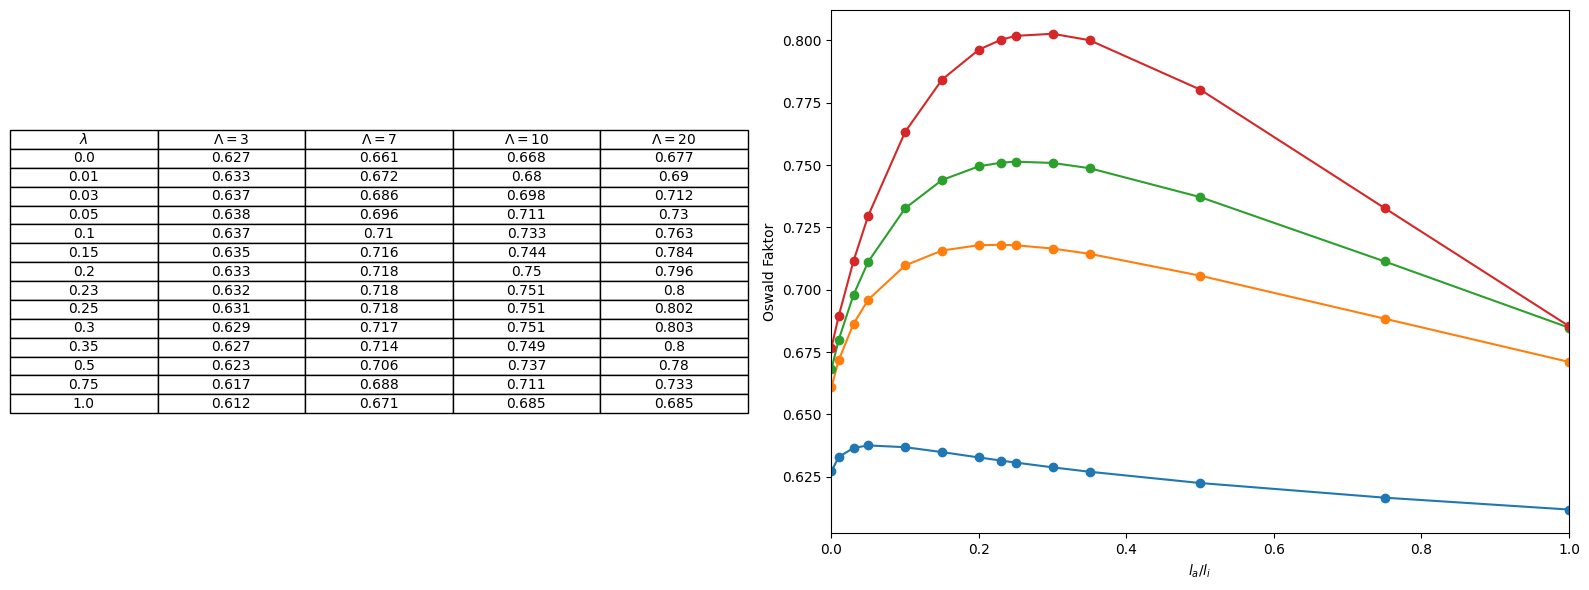

In [483]:
# Ergebnisse plotten
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Erstelle ein DataFrame
df = {
    r'$\lambda$': l_a_study,
    r"$\Lambda = 3$": [round(num, 3) for num in result["3"]],
    r"$\Lambda = 7$": [round(num, 3) for num in result["7"]],
    r"$\Lambda = 10$": [round(num, 3) for num in result["10"]],
    r"$\Lambda = 20$": [round(num, 3) for num in result["20"]]
}
df = pd.DataFrame(df)

for key, val in result.items():
    if key == "lambda":
        pass
    else:
        ax[1].plot(l_a_study, val, "o-", label=r"$\Lambda$ = " + key)

# Erstelle die Tabelle
columns = [r"$\lambda$", r"$\Lambda = 3$", r"$\Lambda = 7$", r"$\Lambda = 10$", r"$\Lambda = 20$"]

ax[0].axis('tight')
ax[0].axis('off')
ax[0].table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

ax[1].set_xlabel(r'$l_a / l_i$')
ax[1].set_ylabel("Oswald Faktor")
plt.xlim([0, 1])
plt.tight_layout()
plt.show()